# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цель исследования** — ответить на вопросы:
1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

## Обзор данных

Познакомимся с предоставленными данными

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
from pymystem3 import Mystem
sns.set(style='whitegrid', palette = 'tab10')
df = pd.read_csv('/datasets/data.csv')
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


В таблице 12 столбцов описывающих информацию о заемщиках. 

Согласно документации к данным:
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

In [3]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Имеется 2174 строки в которых отсутствует информация о трудовом стаже и ежемесячном доходе

In [4]:
print(f'Из них одновременно данные пропущены в обоих: {df[(df.days_employed.isna()) & (df.total_income.isna())].shape[0]}')

Из них одновременно данные пропущены в обоих: 2174


### Дубликаты

In [5]:
print(f'Количество явных дубликатов в данных {df.duplicated().sum()}')

Количество явных дубликатов в данных 54


Проанализируем подробнее каждую характеристику.

### children

In [6]:
df.children.value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В информации о количестве детей обращает на себя внимания 2 типа значений.

-1 может являться или ошибкой ввода данных "через дефис" или символом отсутствия данных.

Из-за отсутствия данных в которых количество детей находится в промежутке 5-20. 20 является либо опечаткой, либо у банка очень выгодные условия кредитования для семей с 20 детьми

### days_employed

In [7]:
df.groupby('income_type', as_index=False).agg({'days_employed':['min', 'mean', 'max']})
# минимум, среднее, максимум для каждого типа в income_type

income_type  days_employed                              
                              min           mean            max
0      безработный  337524.466835  366413.652744  395302.838654
1        в декрете   -3296.759962   -3296.759962   -3296.759962
2      госслужащий  -15193.032201   -3399.896902     -39.954170
3        компаньон  -17615.563266   -2111.524398     -30.195337
4        пенсионер  328728.720605  365003.491245  401755.400475
5  предприниматель    -520.848083    -520.848083    -520.848083
6        сотрудник  -18388.949901   -2326.499216     -24.141633
7          студент    -578.751554    -578.751554    -578.751554

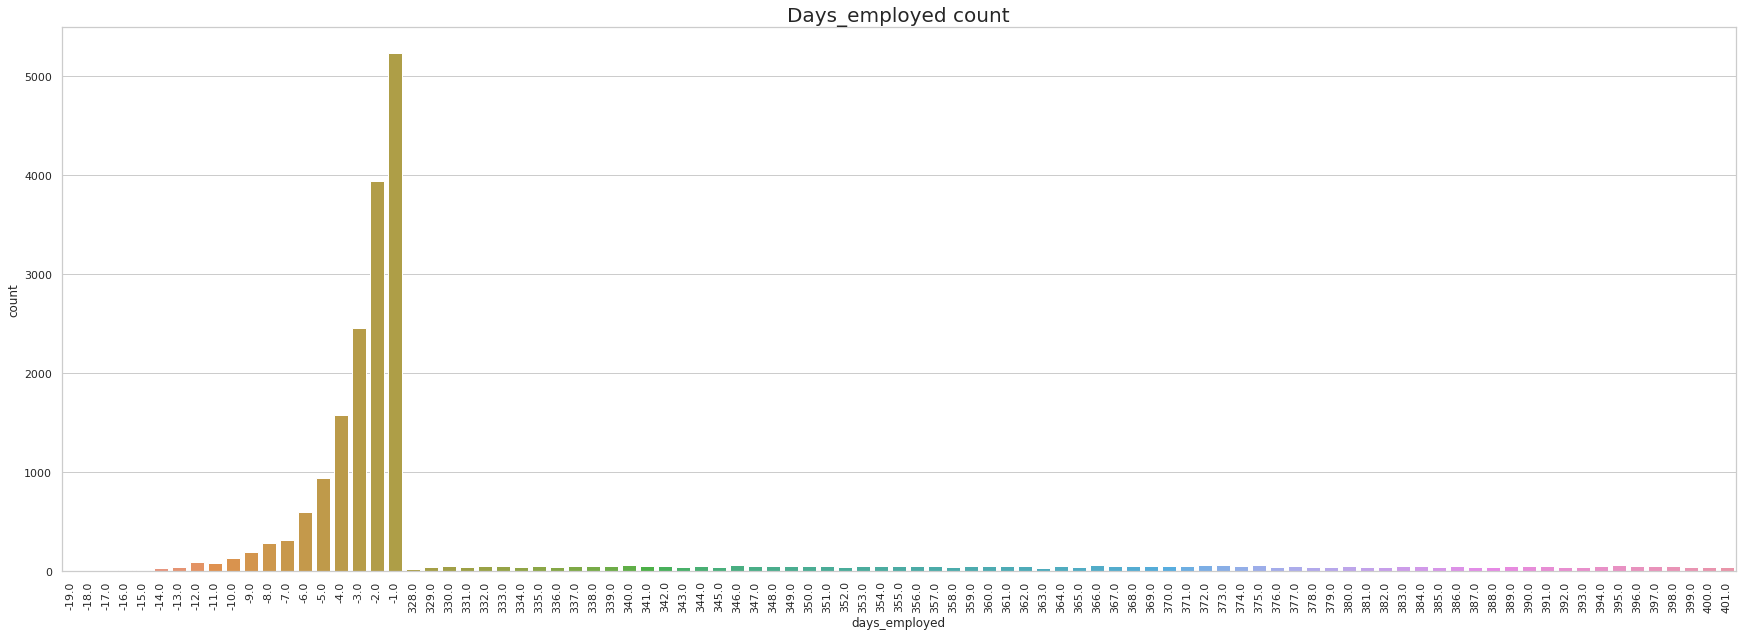

In [8]:
plt.figure(figsize=(30,10))
plt.title('Days_employed сount',  fontsize = 20)
plt.xticks(rotation=90)
sns.countplot(data=df, x=df.days_employed//1000)

В сведениях о трудовом стаже есть 2 типа данных:
1. Положительные значения. Присутвующие исключетельно в строках с заемщиками типа занятости "пенсионер" и "безработный". И представляющие собой величины не совместимые с реальность. Так как в возрасте 60 лет иметь 1000летний стаж работы может быть возможным только в фантастических условиях не рассматриваемых в рамках данной работы.



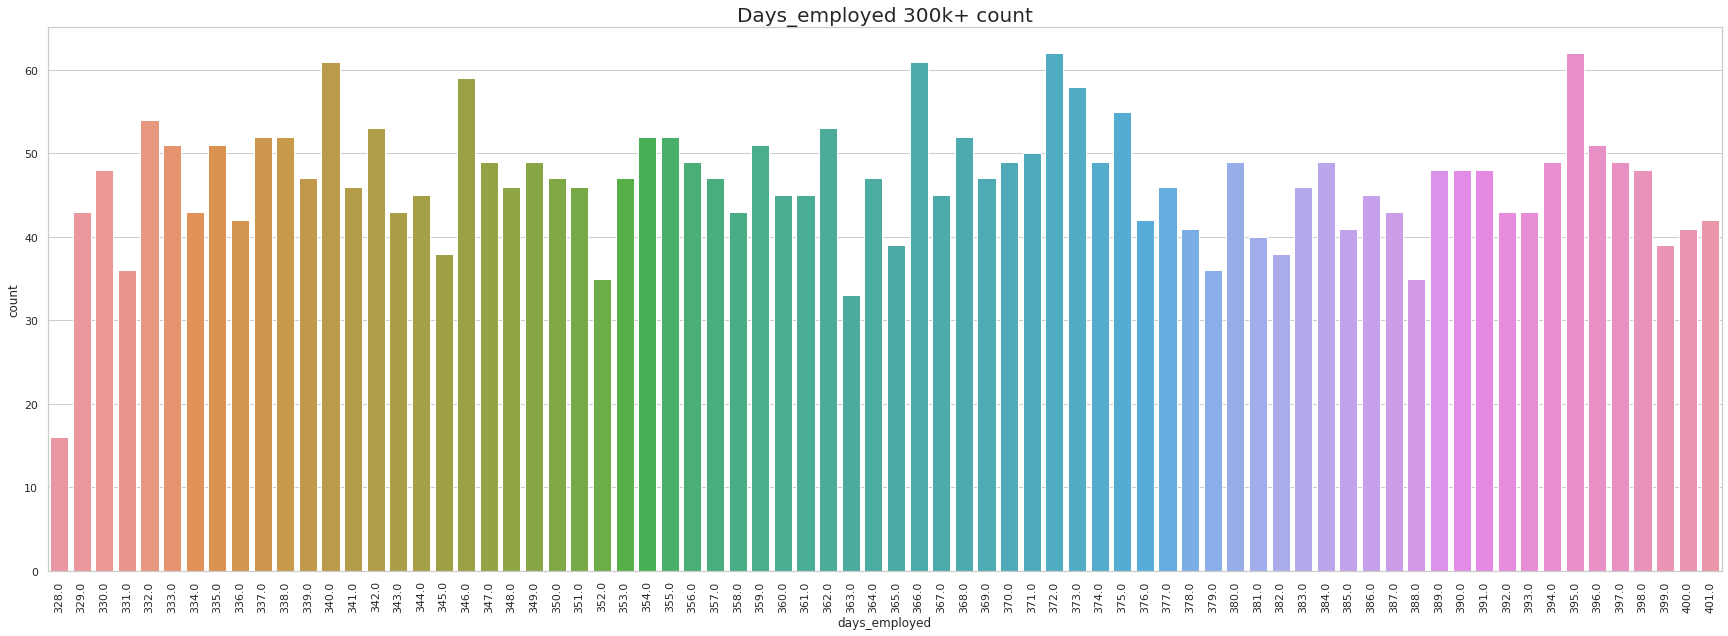

In [9]:
plt.figure(figsize=(30,10))
plt.title('Days_employed 300k+ сount',  fontsize = 20)
plt.xticks(rotation=90)
sns.countplot(data=df[df.days_employed >300000], x=df[df.days_employed >300000].days_employed//1000)
# количество значение тысячной части от days_employed для значенией выше 300тыс

Которые распределены относительно равномерно в промежутке ~328-401 тыс.

2. Отрицательные значения. Количество которых гиперболически убывает с ростом (отрицательным :)) значений. 

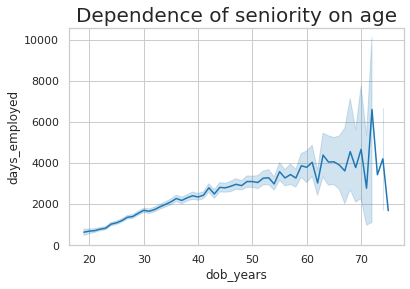

In [10]:
plt.title('Dependence of seniority on age',  fontsize = 20)
sns.lineplot(x=df[(df.income_type != 'пенсионер') &\
                  (df.income_type != 'безработный') & (df.dob_years != 0)].dob_years,\
             y=df[(df.income_type != 'пенсионер') &\
                  (df.income_type != 'безработный') & (df.dob_years != 0)].days_employed.abs())
# зависимость dob_years от модуля days_employed

Отрицательность значений снова спишем на ошибку заполнения данных спобосом "через дефис".  
Для трудового стажа в данных справедлива и логична зависимость, что с увеличением возраста средний показатель отработанных дней также увеличивается

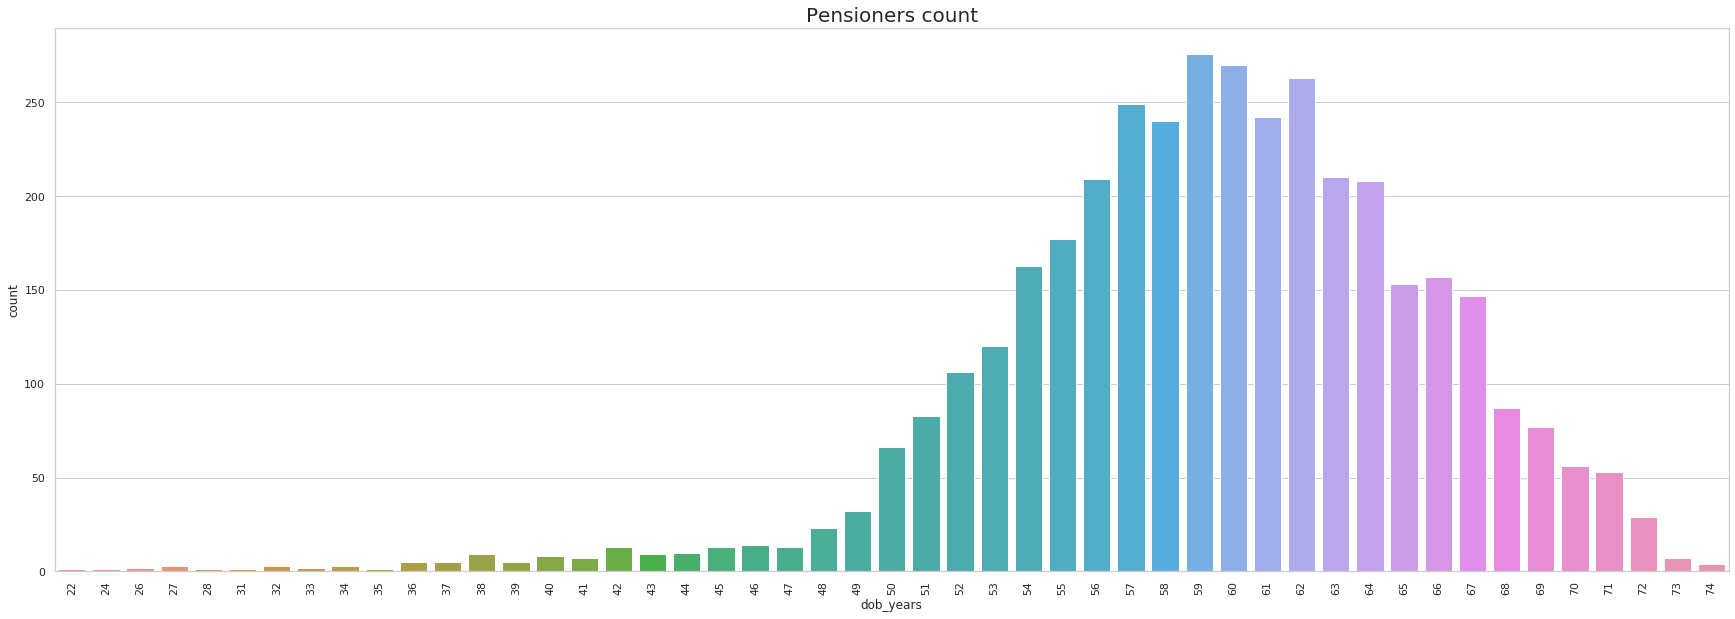

In [11]:
plt.figure(figsize=(30,10))
plt.title('Pensioners count',  fontsize = 20)
plt.xticks(rotation=90)
sns.countplot(data=df[(df.income_type == 'пенсионер') & (df.dob_years != 0)],\
              x=df[(df.income_type == 'пенсионер') & (df.dob_years != 0)].dob_years)

Не зная всех видов государственных льгот, будем считать что эти счасливые (или несчастные) 20-30 летние пенсионеры реальные члены современного общества.  
Наиболее интенсивный рост количества пенсионеров (безработных рассматривать не будем, так как их всего 2) наблюдается от 50 до 60 лет. Следовательно это основной промежуток выхода на пенсию. Логично предположить, что после выхода на пенсию, трудовой стаж не увеличивается.

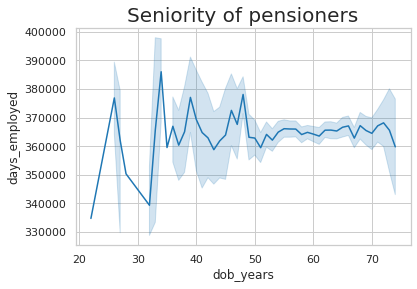

In [12]:
plt.title('Seniority of pensioners',  fontsize = 20)
sns.lineplot(x=df[(df.income_type == 'пенсионер') & (df.dob_years != 0)].dob_years,\
             y=df[(df.income_type == 'пенсионер') & (df.dob_years != 0)].days_employed)

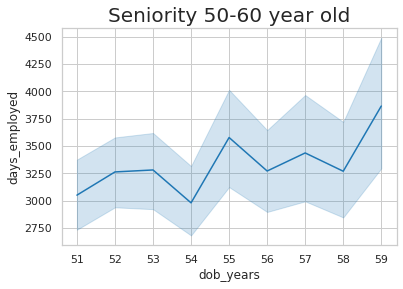

In [13]:
plt.title('Seniority 50-60 year old',  fontsize = 20)
sns.lineplot(x=df[(df.income_type != 'пенсионер') & (df.dob_years > 50) & (df.dob_years < 60)].dob_years,\
             y=df[(df.income_type != 'пенсионер') & (df.dob_years > 50) & (df.dob_years < 60)].days_employed.abs())

При этом средний стаж у работающих в таком возрастном промежутке находится между 3000 и 4000 дней.  
Что совпадает с данными по пенсионерам если их разделить на 100.  
Следовательно, примем теорию, что из-за ошибки при заполнение данных, вероятней всего для пенсионеров значения трудового стажа в днях увеличины в 100 раз.

### dob_years

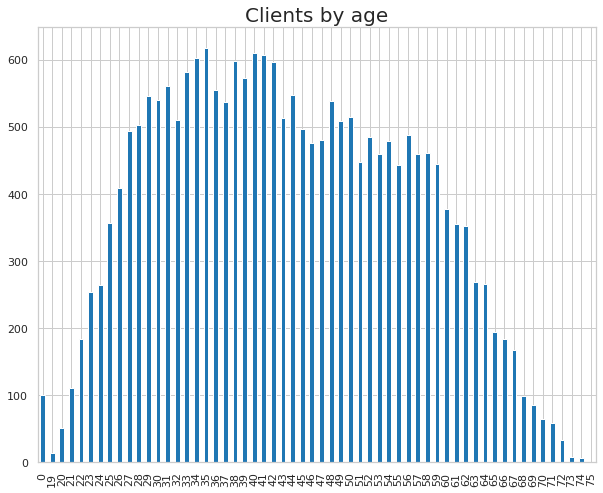

In [14]:
plt.figure(figsize=(10,8))
plt.title('Сlients by age',  fontsize = 20)
df.dob_years.value_counts().sort_index().plot(kind='bar')

В данных о возрасте стоит обратить внимание на 101 значение 0. И задуматься об открытии филиала банка в роддоме

### education

In [15]:
df.education.value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

сТоИт пОДУмАть о пРиВеДЕНИи даННыХ к ЕдИНоМУ сТИлю.

### education_id

In [16]:
df.education_id.value_counts()

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

Первый стобец без замечаний. Жаль что бесполезный.

### family_status

In [17]:
df.family_status.value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

### family_status_id

In [18]:
df.family_status_id.value_counts()

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

Главней всего порядок в доме. А все другое...

### gender

In [19]:
df.gender.value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Есть тёти как тёти,  
Есть дяди как дяди,  
Есть люди как люди...

### income_type

In [20]:
df.income_type.value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Группы из 1 и 2 человек слишком малочисленны для анализа.

### debt

In [21]:
df.debt.value_counts()

0    19784
1     1741
Name: debt, dtype: int64

Каждый 13 заемщик имел задолжности

### total_income

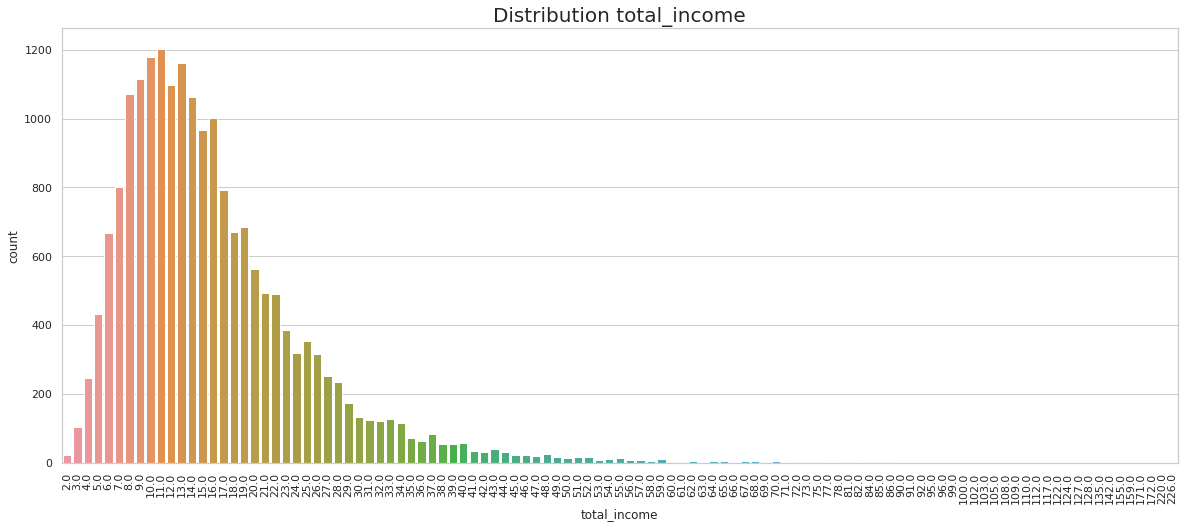

In [22]:
plt.figure(figsize=(20,8))
plt.title('Distribution total_income',  fontsize = 20)
plt.xticks(rotation=90)
sns.countplot(data=df, x=df.total_income//10000)

Богатые тоже ̶~плачут~ занимают

### purpose

In [23]:
df.purpose.value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Разнообразные речевые обороты это конечно хорошо, но не в данном случае.

### Выводы

Так как нет возможности задать дополнительные вопросы о характере данных, необходимо предобработать имеющиеся:
1. Удалить дубликаты.
2. В данных о количестве детей приемем значение 20 за опечатку и заменим на 2. А происхождение величины -1 будем считать написанием "через дефис" и исправим на 1
3. В информации о стаже требуется исправить отрицательные значения на положительные, а стаж для пенсионеров разделить на 100.
4. Следует обработать строки с нулевым возрастом.
5. В колонке с уровенем образования заемщика привести все значения к строчным символам.
6. Проследить в какой туалет пойдет человек XNA пола. 
7. Удалить или перераспределить группы состоящие из малочисленных случаев.

## Предобработка данных

### education

In [24]:
df.education = df.education.str.lower()

In [25]:
df.education.value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

✔ Make education small Again

### Обработка дубликатов

In [26]:
print(f'После обработки регистра, количество явных дубликатов в данных: {df.duplicated().sum()}')

После обработки регистра, количество явных дубликатов в данных: 71


In [27]:
df[df.duplicated()].isna().sum()

children             0
days_employed       71
dob_years            0
education            0
education_id         0
family_status        0
family_status_id     0
gender               0
income_type          0
debt                 0
total_income        71
purpose              0
dtype: int64

Отсутвие значений в самых вариативных колонках `days_employed` и  `total_income` увеличивает вероятность, что найденный дубликат просто окажется уникальной записью заемщика с характеристиками идентичными встречавшимися ранее.  
Для предотвращения в будущем таких неопределенностей банку стоит предоставлять\собирать информацию используя уникальный id заемщика и дату оказания услуги.

В этот раз пожертвуем 71 запись так как это незначительная доля в данных, потеря которых не значительно скажется на результатах.

In [28]:
df = df.drop_duplicates().reset_index(drop=True)

### children

Исходя из предположения что 20 это опечатка при вводе 2, а -1 это 1 записанная с дефисом, исправим исходные данные

In [29]:
df.loc[(df.children == 20), 'children'] = 2 # заменяем 20 на 2
df.loc[:, 'children'] = df.children.abs() # избавляемся от отрицательных значений 

И проверим результат

In [30]:
df.children.value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

### days_employed

Согласно сделанным ранее выводам приведем стаж заемщиков к единообразному виду:  
Изменим знак для отрицательных значений  
Для пенсионеров и безработных разделим стаж на 100

In [31]:
df.loc[:, 'days_employed'] = df.days_employed.apply(lambda x: (x/100) if (x > 300000) else (abs(x)))
# Делим на 100 все значения больше 300000, остальные берем по модулю, чтобы избавиться от отрицательных значений

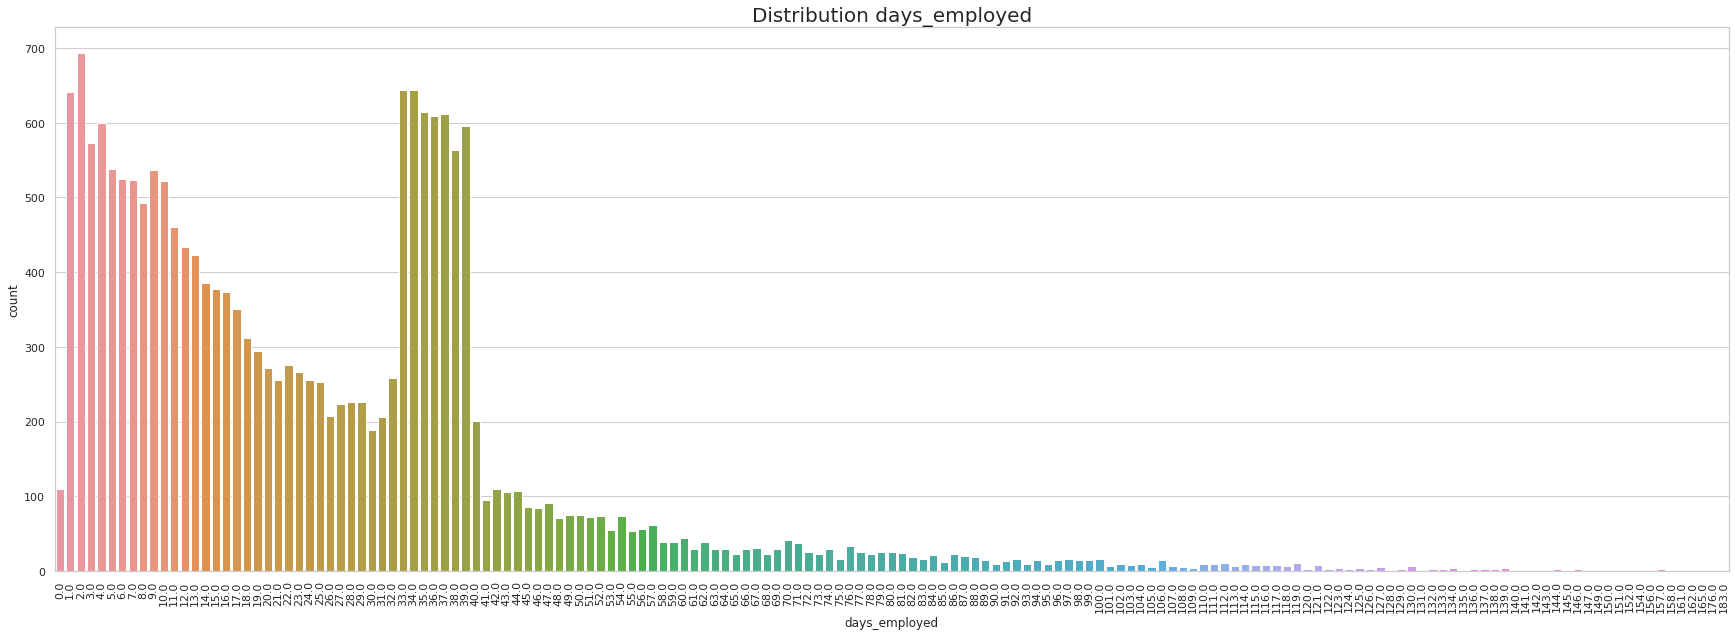

In [32]:
plt.figure(figsize=(30,10))
plt.title('Distribution days_employed',  fontsize = 20)
plt.xticks(rotation=90)
sns.countplot(data=df, x=df.days_employed//100)

В деньгах чаще нуждаются те, кто мало работает или пенсионеры которые своё уже отработали.

### Корреляции в данных.

Рассмотрим взаимозависимости характеристик

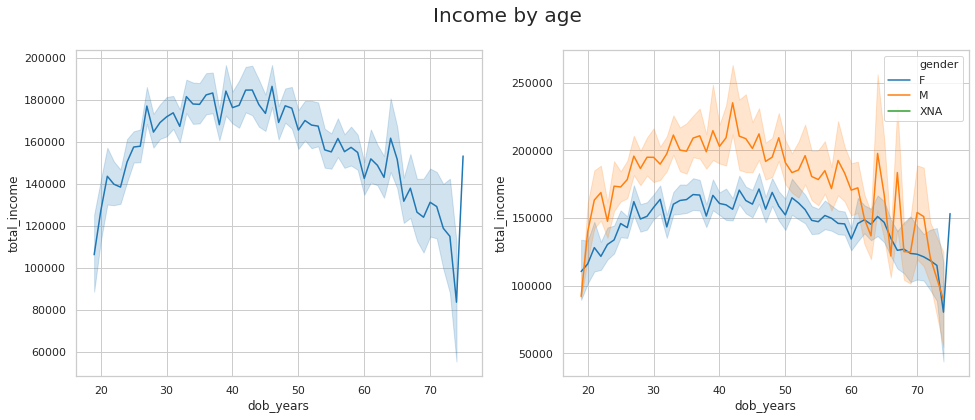

In [33]:
f, axs = plt.subplots(1,2,figsize=(16, 6))
plt.suptitle('Income by age',  fontsize = 20)
sns.lineplot(ax=axs[0], x=df[df.dob_years != 0].dob_years, y=df[df.dob_years != 0].total_income)
sns.lineplot(ax=axs[1], x=df[df.dob_years != 0].dob_years, y=df[df.dob_years != 0].total_income, hue=df.gender)

Средний ежемесячный доход растет до 40 лет, а после убывает. Зависимости для мужчин и женщин отличаются.

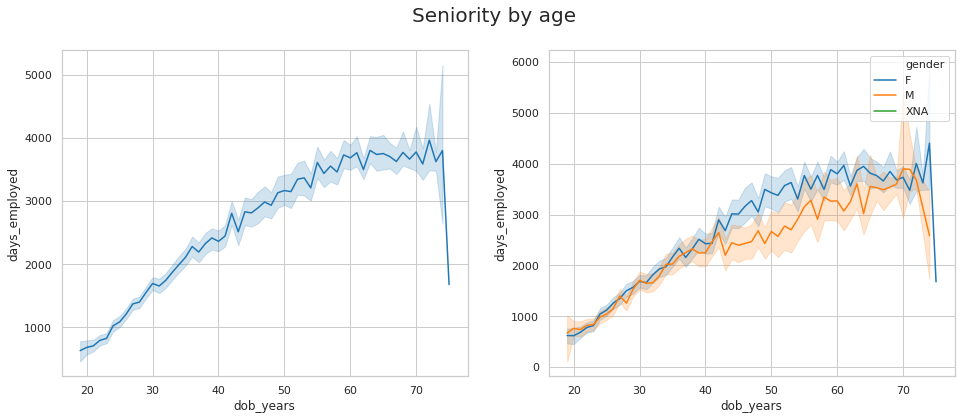

In [34]:
f, axs = plt.subplots(1,2,figsize=(16, 6))
plt.suptitle('Seniority by age',  fontsize = 20)
sns.lineplot(ax=axs[0], x=df[df.dob_years != 0].dob_years, y=df[df.dob_years >18].days_employed)
sns.lineplot(ax=axs[1], x=df[df.dob_years != 0].dob_years, y=df[df.dob_years > 18].days_employed, hue=df.gender)

Снова все логично. Чем больше живешь тем больше работаешь.  
Женщины больше работают и меньше зарабатывают. Не показывайте эти графики феминисткам.

На графиках хорошо заметен выброс.

In [35]:
df[df.dob_years > 74]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
8870,0,1678.969771,75,среднее,1,вдовец / вдова,2,F,госслужащий,0,153282.648133,заняться образованием


75летний госслужащий. Практически не работавший, но с высоким доходом.  
Уберем его хотя бы из наших данных.

In [36]:
df = df.drop(index=[8870])

In [37]:
df[(df.gender != 'F') & (df.gender != 'M')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10684,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


По ежемесечному доходу наш XNA-gender вероятнее принадлежит к обладателю Y-хромосомы, туда его и зачислим.

In [38]:
df.loc[10684, 'gender'] = 'M'

Те записи, в которых отсутвуют данные и о возрасте, и о стаже и о доходе 

In [39]:
df_three_na = df[(df.dob_years == 0) & (df.days_employed.isna() == True)]
df_three_na # DataFrame в котором все записи из df c dob_years = 0, days_employed = NaN и total_income = NaN

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
1890,0,NaN,0,высшее,0,Не женат / не замужем,4,F,сотрудник,0,NaN,жилье
2284,0,NaN,0,среднее,1,вдовец / вдова,2,F,пенсионер,0,NaN,недвижимость
4062,1,NaN,0,среднее,1,гражданский брак,1,M,компаньон,0,NaN,ремонт жилью
5010,0,NaN,0,среднее,1,женат / замужем,0,F,компаньон,0,NaN,покупка недвижимости
6405,0,NaN,0,высшее,0,гражданский брак,1,F,пенсионер,0,NaN,свадьба
6664,0,NaN,0,высшее,0,в разводе,3,F,пенсионер,0,NaN,покупка жилой недвижимости
8565,0,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,недвижимость
12381,3,NaN,0,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,операции с коммерческой недвижимостью
13716,0,NaN,0,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,на проведение свадьбы
19770,0,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,жилье


Будут скорее затруднять, а не способствовать дальнейшему анализу.  
Поэтому продолжим без них.

In [40]:
df = df.loc[~df.index.isin(df_three_na.index)] # убираем из df все записи собранные в df_three_na

По 1-2 представителям отраслей и профессий зависимостей не построить, поэтому их также исключим из оцениваемых данных.

In [41]:
df.query("income_type in ['предприниматель', 'безработный', 'студент', 'в декрете']")

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3132,1,3375.244668,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
5931,0,NaN,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости
9399,0,578.751554,22,высшее,0,Не женат / не замужем,4,M,студент,0,98201.625314,строительство собственной недвижимости
14767,0,3953.028387,45,высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью
18647,0,520.848083,27,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы
20778,2,3296.759962,39,среднее,1,женат / замужем,0,F,в декрете,1,53829.130729,автомобиль


In [42]:
df = df.loc[~df.index.isin(df.query("income_type in ['предприниматель', 'безработный', 'студент', 'в декрете']").index)]
# убираем из df все записи с income_type в которых по 1-2 значения

Посмотрим также на наличие различий между группами занятости 

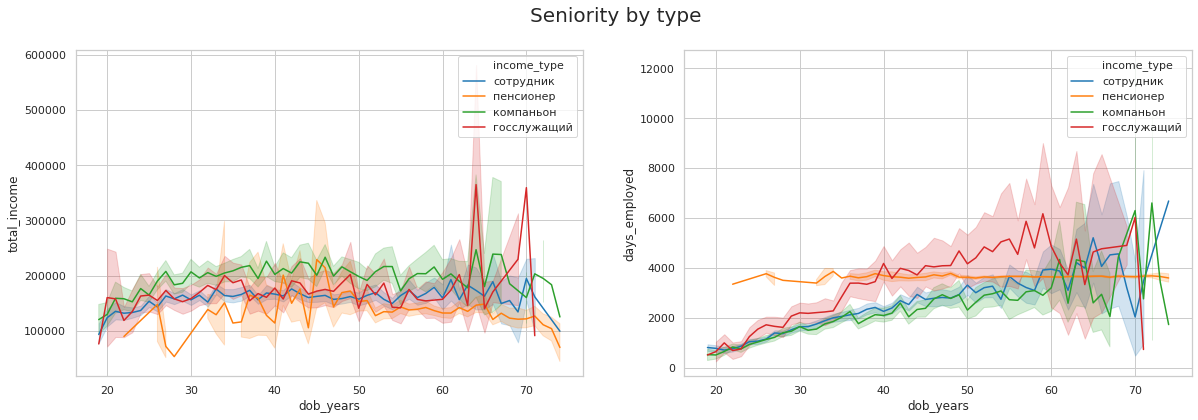

In [43]:
f, axs = plt.subplots(1,2,figsize=(20, 6))
plt.suptitle('Seniority by type',  fontsize = 20)
sns.lineplot(ax=axs[0], x=df[df.dob_years != 0].dob_years, y=df.total_income, hue=df.income_type)
sns.lineplot(ax=axs[1], x=df[df.dob_years != 0].dob_years, y=df.days_employed, hue=df.income_type)

Заемщик пенсионер и госслужащий имеют возрастные промежутки в которых средний стаж выше чем у остальных типов занятости. 

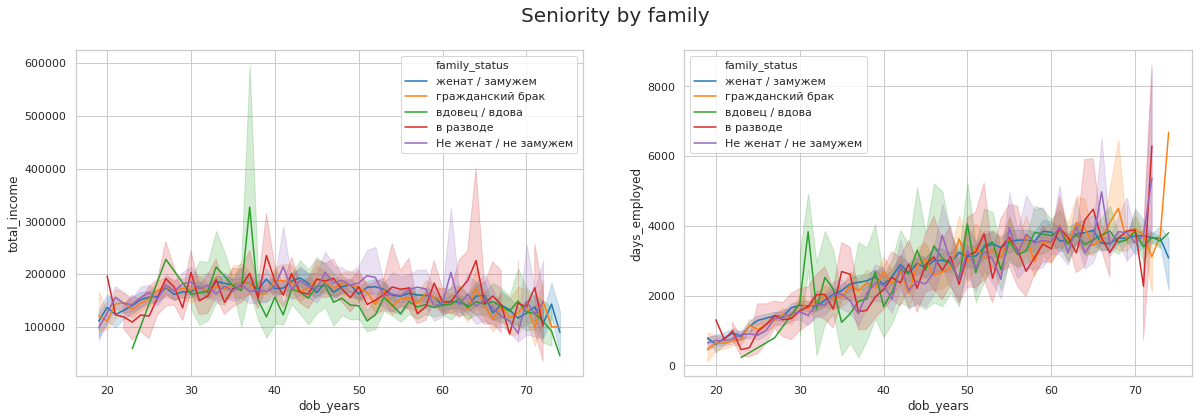

In [44]:
f, axs = plt.subplots(1,2,figsize=(20, 6))
plt.suptitle('Seniority by family',  fontsize = 20)
sns.lineplot(ax=axs[0], x=df[df.dob_years != 0].dob_years, y=df.total_income, hue=df.family_status)
sns.lineplot(ax=axs[1], x=df[df.dob_years != 0].dob_years, y=df.days_employed, hue=df.family_status)

А вот с точки зрения семейного положения все равны.

Вооружившись новыми знаниями, заменим все нулевые значения возраста на средний возраст заемщиков с аналогичным стажем, доходом, полом и типом занятости.

In [45]:
df_without_zero = df.loc[~df.index.isin(df[df.dob_years == 0].index)]
# DataFrame в котором все записи из df c dob_years != 0

In [46]:
def age_calc(df, row): # принимает DataFrame с данными и строку
    res = df[(df.days_employed < row.days_employed+1000) &\
              (df.days_employed > row.days_employed-1000) &\
              (df.total_income < row.total_income+20000) &\
              (df.total_income > row.total_income-20000) &\
              (df.gender == row.gender) & (df.income_type == row.income_type)]    
    if res.shape[0]>6: # Сравнивает с схожими записями если смог найти больше 6 записей
        return int(res.dob_years.mean()) # Возвращает среднее значение возраста
    else: # Если не смог найти 6 схожих записей, то снова ищет не учитывая показатель income_type
        return int(df[(df.days_employed < row.days_employed+1000) &\
                      (df.days_employed > row.days_employed-1000) &\
                      (df.total_income < row.total_income+20000) &\
                      (df.total_income > row.total_income-20000) &\
                      (df.gender == row.gender)].dob_years.mean()) # Возвращает среднее значение возраста

In [47]:
df.loc[(df.dob_years == 0), 'dob_years'] = df[df.dob_years == 0].apply(lambda x: age_calc(df_without_zero, x), axis=1)
# Для каждой строки с нулевым возрастом, найти схожие записи по остальным показателям и взять из них средний возраст

In [48]:
print(f' Количество записей с нулевым возрастом после обработки данных: {df[df.dob_years == 0].shape[0]}')

 Количество записей с нулевым возрастом после обработки данных: 0


In [49]:
print(f' Количество возможных вариантов возраста в имеющемся промежутке: {df.dob_years.max()+1-df.dob_years.min()}')
print(f' Количество имеющихся вариантов возраста в имеющемся промежутке: {df.dob_years.nunique()}')

 Количество возможных вариантов возраста в имеющемся промежутке: 56
 Количество имеющихся вариантов возраста в имеющемся промежутке: 56


Имея данные по каждому возрасту, аналогичным способом, но теперь в обратной зависимости заполняем отсутствующие данные в колонках `days_employed` и `total_income`

In [50]:
def worth_calc(df, row): # принимает DataFrame с данными и строку
    with_income_type = df[(df.dob_years == row.dob_years) & (df.gender == row.gender)\
              & (df.income_type == row.income_type)].days_employed.mean(),\
            df[(df.dob_years == row.dob_years) & (df.gender == row.gender)].total_income.mean()
    if sum(with_income_type)>max(with_income_type): #сравнение с NaN всегда выдает False
        return with_income_type #Если записей достаточно чтобы взять средний и days_employed и total_income возращает его
    else: #Иначе берет записи не учитывая income_type для days_employed
        return df[(df.dob_years == row.dob_years) & (df.gender == row.gender)].days_employed.mean(),\
    df[(df.dob_years == row.dob_years) & (df.gender == row.gender)].total_income.mean() #Возращает средние
    
    
   

In [51]:
df.loc[(df.days_employed.isna()), ['days_employed', 'total_income']] =\
df[df.days_employed.isna()].apply(lambda x: worth_calc(df, x), axis=1).tolist()
# Для каждой строки с пропущенными значениями в days_employed и total_income,
#найти схожие записи по остальным показателям и взять из них средние days_employed и total_income

Убедимся в том, что все пропуски заполнены

In [52]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Настало время преобразовать `days_employed` и `total_income` в целочисленные значения.

In [53]:
df.days_employed = df.days_employed.astype(int) #days_employed float->int
df.total_income = df.total_income.astype(int) #total_income float->int

### Лемматизация `purpose`

Подключаем лемматизатор

In [54]:
myst = Mystem()

Освежим снова в памяти содержимое `purpose`

In [55]:
df.purpose.sort_values().unique() 

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Все значения можно разбить на 6 категорий:  
1. Свадьба
2. Коммерческий займ
3. Недвижимость
4. Автомобиль
5. Образование

In [56]:
def lema(row): # Берет строку
    targets = myst.lemmatize(row.purpose) # Лемматизирует значение в purpose
    for target in targets: # ищет соответствия объявленным категориям
        if target in ['свадьба', 'коммерческий', 'недвижимость', 'жилье', 'автомобиль', 'образование']:
            return target if target != 'жилье' else 'недвижимость' # присваивает категорию. недвижимость == жилье

Преобразуем содержание `purpose` к выбранным категориям.

In [57]:
df.purpose = df.apply(lema, axis=1) # меняем значение в purpose на выбранные категории

In [58]:
df.purpose.value_counts()

недвижимость    9489
автомобиль      4305
образование     4012
свадьба         2321
коммерческий    1310
Name: purpose, dtype: int64

## Подготовка данных к анализу.

In [59]:
df_summary = df.copy() #создаем копию которую будем преобразовывать для анализа

На выборке такого размера, излишне точные показатели будут скорей размывать общую картину, поэтому сгрупируем имеющиеся данный по группам.

По количеству детей информацию перегрупируем по 3 видам :
1. Бездетные
2. 1-2 ребенка
3. Многодетные

In [60]:
df_summary.children = df_summary.children.map({0: 'not',
                                               1: 'one/two',
                                               2: 'one/two',
                                               3: 'large',
                                               4: 'large',
                                               5: 'large'}) # переход от количесва к категориям

Трудовой стаж округлим до тысяч дней.

In [61]:
Counter((df_summary.days_employed//1000).sort_values()) # количество значений days_employed выраженные в тысячах без остатка  

Counter({0: 5324,
         1: 4438,
         2: 3162,
         3: 5622,
         4: 1094,
         5: 617,
         6: 317,
         7: 281,
         8: 193,
         9: 129,
         10: 84,
         11: 86,
         12: 35,
         13: 30,
         14: 12,
         15: 8,
         16: 3,
         17: 1,
         18: 1})

А всех у кого стаж более 10 тыс. дней из-за малочисленности припишем к группе десятитысячников.

In [62]:
df_summary.days_employed = df_summary.days_employed.apply(lambda x: (x//1000) if (x < 10000) else (10))
# дни переводим в тысячи дней, больше 10000 присваиваем 10

Возрастные промежутки разобьем на десятилетия.

In [63]:
df_summary.dob_years = df_summary.dob_years.apply(lambda x: f'{x//10*10}-{x//10*10+9}' if (x > 19) else ('19'))
# для значений больше 19 переходим от значений в годах, к десятилетиям

Взглянем на ежемесячный доход в группах с шагом в 10 тысяч.

In [64]:
Counter((df_summary.total_income//10000).sort_values())
# количество значений total_income выраженные в десятках тысяч без остатка  

Counter({2: 22,
         3: 103,
         4: 247,
         5: 432,
         6: 668,
         7: 802,
         8: 1072,
         9: 1115,
         10: 1179,
         11: 1209,
         12: 1152,
         13: 1246,
         14: 1430,
         15: 1387,
         16: 1479,
         17: 938,
         18: 761,
         19: 867,
         20: 745,
         21: 553,
         22: 492,
         23: 409,
         24: 318,
         25: 354,
         26: 317,
         27: 252,
         28: 234,
         29: 173,
         30: 134,
         31: 126,
         32: 121,
         33: 128,
         34: 115,
         35: 72,
         36: 64,
         37: 84,
         38: 55,
         39: 55,
         40: 58,
         41: 35,
         42: 32,
         43: 39,
         44: 32,
         45: 22,
         46: 24,
         47: 20,
         48: 26,
         49: 17,
         50: 15,
         51: 17,
         52: 18,
         53: 8,
         54: 10,
         55: 13,
         56: 8,
         57: 8,
         58: 6,
  

Разобьем всех заемщиков на 4 равные группы основываясь на ежемесечном доходе.  
Группа с наименьшим доходом - "низкий". Остальные по возрастанию соответственно "средний", "выше среднего", "высокий".

In [65]:
df_summary.total_income = pd.qcut(df_summary['total_income'],
                                  4, labels=["низкий", "средний", "выше среднего", "высокий"])

Изменим название колонок на то, чему они теперь соответствуют и уберем лишнее 

In [66]:
df_summary.rename(columns={'days_employed': 'thousand_days_employed',
                            'dob_years': 'ten_years',
                            'total_income': 'income_level'}, inplace=True)
df_summary.drop(['education_id', 'family_status_id'], axis=1, inplace=True)
# дублирующие значения id нам не нужны

Посмотрим на получившиеся данные.

In [67]:
df_summary

,children,thousand_days_employed,ten_years,education,family_status,gender,income_type,debt,income_level,purpose
0,one/two,8,40-49,высшее,женат / замужем,F,сотрудник,0,высокий,недвижимость
1,one/two,4,30-39,среднее,женат / замужем,F,сотрудник,0,средний,автомобиль
2,not,5,30-39,среднее,женат / замужем,M,сотрудник,0,средний,недвижимость
3,large,4,30-39,среднее,женат / замужем,M,сотрудник,0,высокий,образование
4,not,3,50-59,среднее,гражданский брак,F,пенсионер,0,выше среднего,свадьба
...,...,...,...,...,...,...,...,...,...,...
21449,one/two,4,40-49,среднее,гражданский брак,F,компаньон,0,высокий,недвижимость
21450,not,3,60-69,среднее,женат / замужем,F,пенсионер,0,выше среднего,автомобиль
21451,one/two,2,30-39,среднее,гражданский брак,M,сотрудник,1,низкий,недвижимость
21452,large,3,30-39,среднее,женат / замужем,M,сотрудник,1,высокий,автомобиль


И оценим существует ли различие между сформированными группами в долях заемщиков с задолжностями.

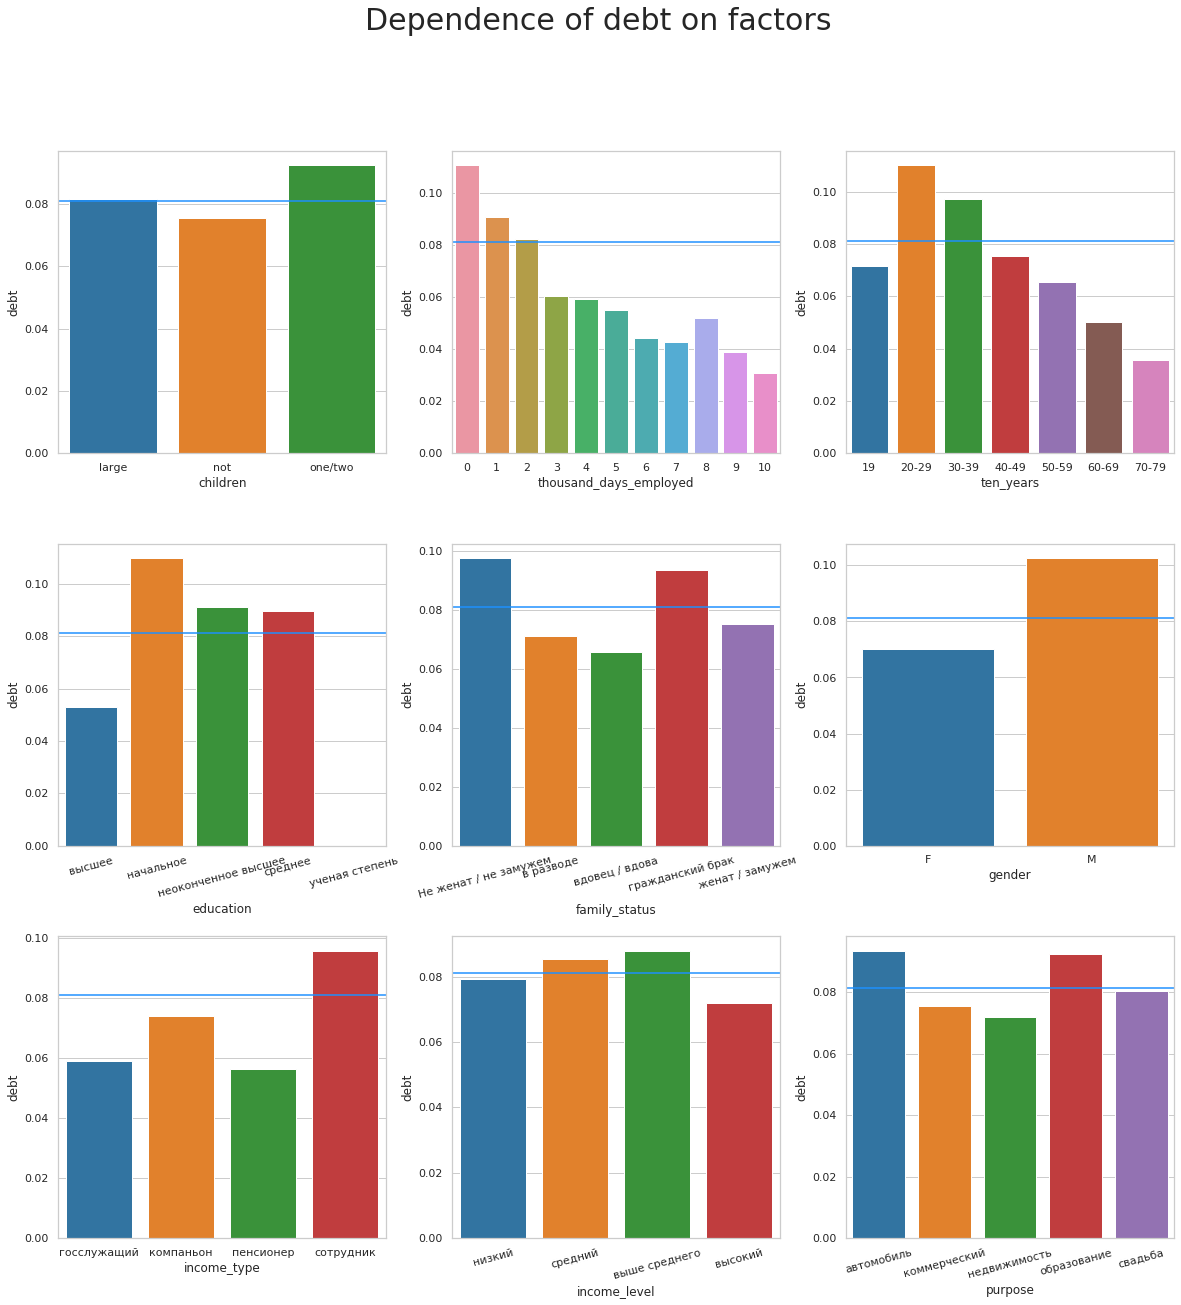

In [68]:
f, axs = plt.subplots(3,3,figsize=(20,20)) # поле 3х3 для гистограмм
plt.subplots_adjust(hspace=0.3)
axs=axs.ravel()
plt.suptitle('Dependence of debt on factors', fontsize = 30)
for i, col in enumerate(df_summary.columns.drop('debt')):
    g = sns.barplot(ax=axs[i], data=df_summary,\
                    x=df_summary.groupby(col).debt.mean().index,\
                    y=df_summary.groupby(col).debt.mean())
    if i in [3,4,7,8]:
        g.set_xticklabels(g.get_xticklabels(),rotation=15)

    axs[i].axhline(y=df_summary.debt.mean(), c='dodgerblue') #линия среднего значения debt для всей выборки

Для анализа влияния каждого из факторов создадим таблицу со значениями доли заемщиков в выборке исключающей данный фактор и доли состоящей исключительно из заемщиков с рассматриваемым фактором.

In [69]:
valuedf = pd.DataFrame(columns=['column_name','column_value','debt_without_mean','sample_mean','p_value'])

In [70]:
for col_name in df_summary.columns.drop('debt'): # Перебираем характеристики
    for value_name in df_summary[col_name].sort_values().unique().tolist(): # Перебираем каждую группу в характеристике
        sample = df_summary[df_summary[col_name] == value_name] #выборка с фактором
        df_without = df_summary.loc[~df_summary.index.isin(sample.index)] #выборка без фактора
        valuedf = valuedf.append({'column_name' : col_name,
                                  "column_value": value_name,
                                  "debt_without_mean": df_without.debt.mean(),
                                  "sample_mean": sample.debt.mean(),
                                  "p_value": stats.ttest_ind(sample.debt, df_without.debt)[1]}, ignore_index=True)
                                #оценка статистической значимости по t-критерию Стьюдента 

Для визуализации посчитаем какого относительное влияние каждого из факторов

In [71]:
valuedf['percentage_difference'] = (valuedf.sample_mean/valuedf.debt_without_mean*100)-100

И оставим только статистически значимые изменения

In [72]:
result = valuedf[valuedf.p_value < 0.05].sort_values(by='percentage_difference') 
# при p_value < 0.05 принимаем влияние статистически значимым
result

,column_name,column_value,debt_without_mean,sample_mean,p_value,percentage_difference
13,thousand_days_employed,10,0.081740,0.030769,2.770534e-03,-62.357019
20,ten_years,70-79,0.081480,0.035714,3.045229e-02,-56.168082
10,thousand_days_employed,7,0.081632,0.042705,1.757956e-02,-47.686215
9,thousand_days_employed,6,0.081676,0.044164,1.517650e-02,-45.927856
21,education,высшее,0.090219,0.053023,9.423919e-18,-41.228218
19,ten_years,60-69,0.084895,0.050193,6.821346e-09,-40.876177
35,income_type,пенсионер,0.086480,0.056456,6.928200e-10,-34.718083
8,thousand_days_employed,5,0.081892,0.055105,1.631555e-02,-32.710067
6,thousand_days_employed,3,0.088524,0.060299,2.722301e-11,-31.883862
31,gender,F,0.102543,0.070117,1.727273e-16,-31.621617


Переименуем факторы в более презентабельный вид

In [73]:
result.column_name =  result.column_name.map({'thousand_days_employed': 'Стаж тыс. дней:',
                                              'income_level': 'Доход:',
                                              'ten_years': 'В возрасте',
                                              'education': 'Образование',
                                              'income_type': 'Занятость:',
                                              'gender': 'Пол',
                                              'family_status': 'Cемейный статус:',
                                              'children': 'Наличие детей',
                                              'purpose': 'Целью кредита:'})

И визуализируем

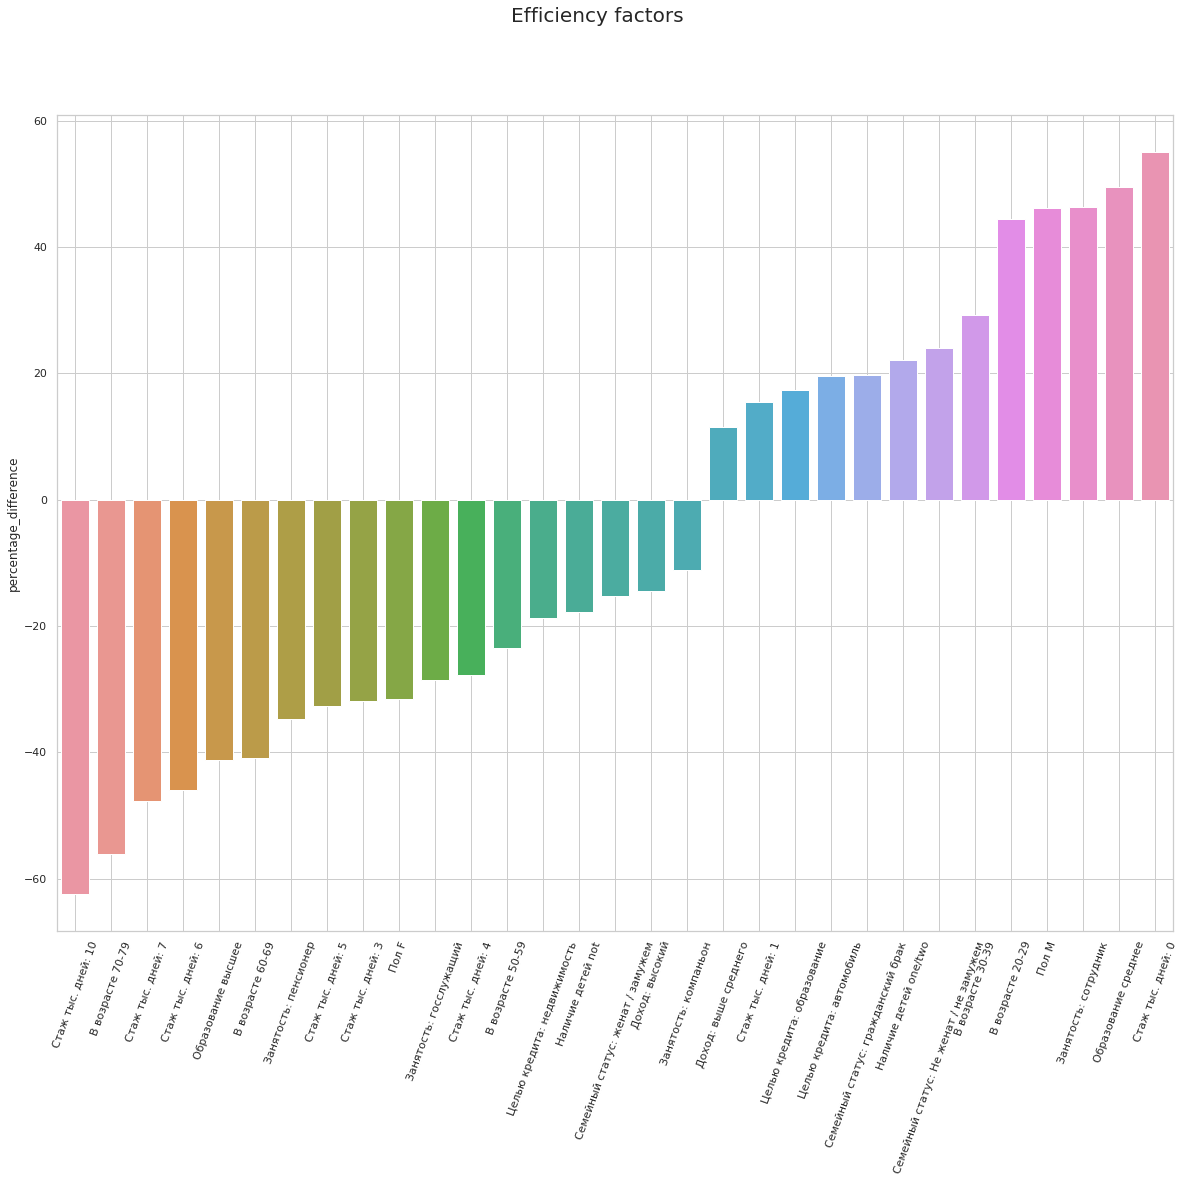

In [74]:
plt.figure(figsize=(20, 15))
plt.suptitle('Efficiency factors',  fontsize = 20)
plt.xticks(rotation=70)
ax = sns.barplot(data=result,
                 x=result.apply(lambda x: f'{x.column_name} {x.column_value}', axis=1),
                 y=result['percentage_difference'])
ax.xaxis.grid(True)

## Выводы

1. Есть ли зависимость между наличием детей и возвратом кредита в срок?  
В среднем заемщики без детей имеют задолжности на 17% реже, а заемщики с 1-2 детьми на 22% чаще.  

2. Есть ли зависимость между семейным положением и возвратом кредита в срок?    
В среднем женатые/замужние заемщики имеют задолжности на 15% реже, а заемщики не женатые/не замужение на 24% чаще. Состоящие же в гражданском браже на 19% чаще.

3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?  
В среднем заемщики с высоким доходом имеют задолжности на 14% реже, а заемщики с доходом выше среднего на 11% чаще.

4. По совокупности факторов портрет наиболее добросовестного заемщика выглядит как женщина пристарелого возраста с большим скажем работы и высшим образованием.

5. Портрет заемщика с повышеными рисками это молодой мужчина с небольшим стажем работ и средним образованием